This notebook will be used to look at and understand the model output currents through Haro Strait with the use of ellipses

In [2]:
import os
import datetime
import matplotlib.pylab as plt
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import csv
import pandas as pd
import subprocess as sp
from subprocess import Popen, PIPE

import netCDF4 as nc
from salishsea_tools import viz_tools

%matplotlib inline

#Which grid points do we want to focus on?

In [3]:
thalweg = np.loadtxt('/data/dlatorne/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)
grid = '/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
fB = nc.Dataset(grid)
bathy = fB.variables['Bathymetry'][:]
lons = fB.variables['nav_lon'][:]
lats = fB.variables['nav_lat'][:]

In [4]:
#Haro Strait
iH = 233
jH = 312

[210, 250, 280, 360]

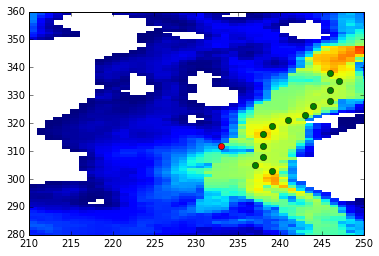

In [5]:
plt.pcolormesh(bathy)
plt.plot(iH,jH,'ro')
plt.plot(thalweg[1,480:530:4],thalweg[0,480:530:4], 'go')
plt.axis([210,250,280,360])

##Loading parameters
The parameters have been calculated in [SaveTidalParameters](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Muriel/SaveTidalParameters.ipynb) because they take a long time to load and are consitent for a chosen time period.

In [6]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 6, 29)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

loc = np.arange(480,530,4)
count = np.arange(0,len(loc))
parh = np.zeros((len(loc),39,5))
parh_av = np.zeros((len(loc),8))
cols=np.arange(0,5)

i = np.zeros((16))
j = np.zeros((16))


for k,l in zip(loc,count):
    i = thalweg[1,loc]
    j = thalweg[0,loc]
    runname1 = '{}_{}_HaroS_{}'.format(t_o, t_f, k)
    runname2 = '{}_{}_HaroS_{}_depav(0-400)'.format(t_o, t_f, k)
    df1 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/HaroStrait/'+runname1+'.csv', usecols=cols) 
    df2 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/HaroStrait/'+runname2+'.csv', index_col=False)
    parh[l,:,:] = df1.as_matrix()
    parh_av[l,:] = df2.as_matrix()


##Model Ellipses with Depth

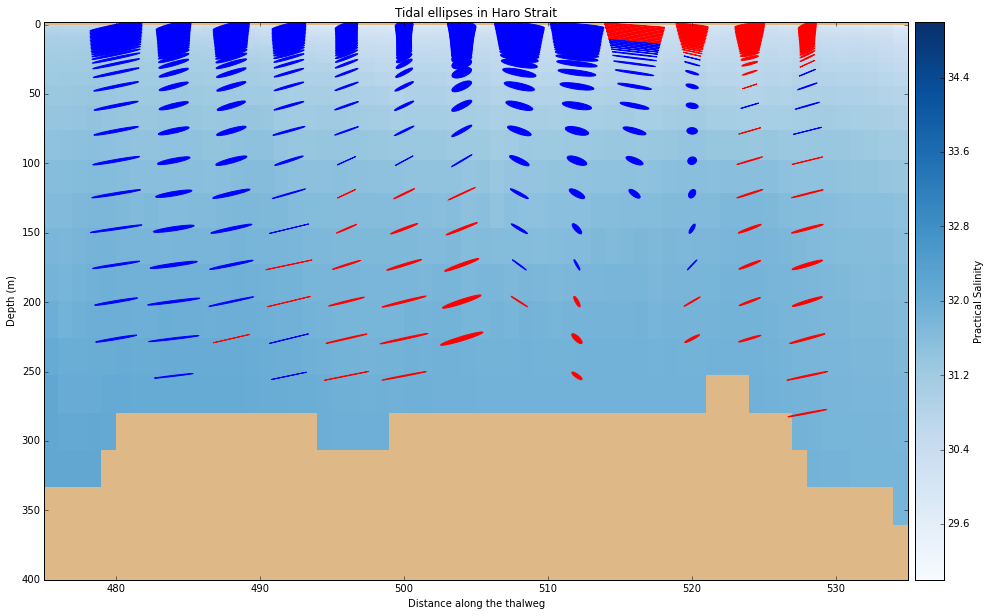

In [7]:
# Set up the figure and axes
fig, (axl, axcb) = plt.subplots(1, 2, figsize=(20, 10))
land_colour = 'burlywood'
axl.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))

smin, smax, dels = 29, 35, 0.5
cmap = plt.get_cmap('Blues')
cmap.set_bad(land_colour)
tracers = nc.Dataset('/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/18sep27sep/SalishSea_1d_20030918_20030927_grid_T.nc')
sal = tracers.variables['vosaline']
npsal = sal[:]
zlevels = tracers.variables['deptht']
sal_0 = npsal[-1, :, thalweg[0], thalweg[1]]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(np.arange(thalweg.shape[1]), zlevels)
mesh = axl.pcolormesh(x, z, sal_tzyx.T, cmap=cmap, vmin=smin, vmax=smax)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity')

scale = 10
for c, ind in zip(count, loc):
    for dep, value in zip(np.arange(0,39), parh[0,:,0]):
        if parh[c,dep,2] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ellsc = Ellipse(xy=(ind, value), width=scale*parh[c,dep,1], 
                            height=scale*parh[c,dep,2], angle=parh[c, dep,3],
                            color=thec)
        axl.add_artist(ellsc)
        ellsc.set_facecolor(thec)

axl.set_ylim(-2,400)
axl.invert_yaxis()
axl.set_xlim(475,535)
axl.set_title('Tidal ellipses in Haro Strait')
axl.set_ylabel('Depth (m)')
axl.set_xlabel('Distance along the thalweg')

They are mostly going northwards... larger values at the surface

##Load Foreman values

In [8]:
i = thalweg[1,loc]
j = thalweg[0,loc]

lon = lons[j,i]
lat = lats[j,i]
print lat, lon

[ 48.51210785  48.51619339  48.52997589  48.54579926  48.5616188
  48.57539368  48.58712006  48.59884644  48.61261749  48.62434006
  48.64014435  48.65390778  48.66384888] [-123.16444397 -123.18154144 -123.18635559 -123.19971466 -123.21307373
 -123.21788788 -123.2141571  -123.21042633 -123.21524048 -123.21151733
 -123.22489166 -123.22971344 -123.24494934]


In [9]:
parhf = np.zeros((13,4))
os.chdir(r'/ocean/mdunn/Tides/')
for k in count:
    p = Popen(["matlab","-nodesktop","-nodisplay","-r", "findparam(%s,%s)" % (lon[k], lat[k])], stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    parhf[k] = np.loadtxt('output.txt')

##Map of ellipses

red is clockwise


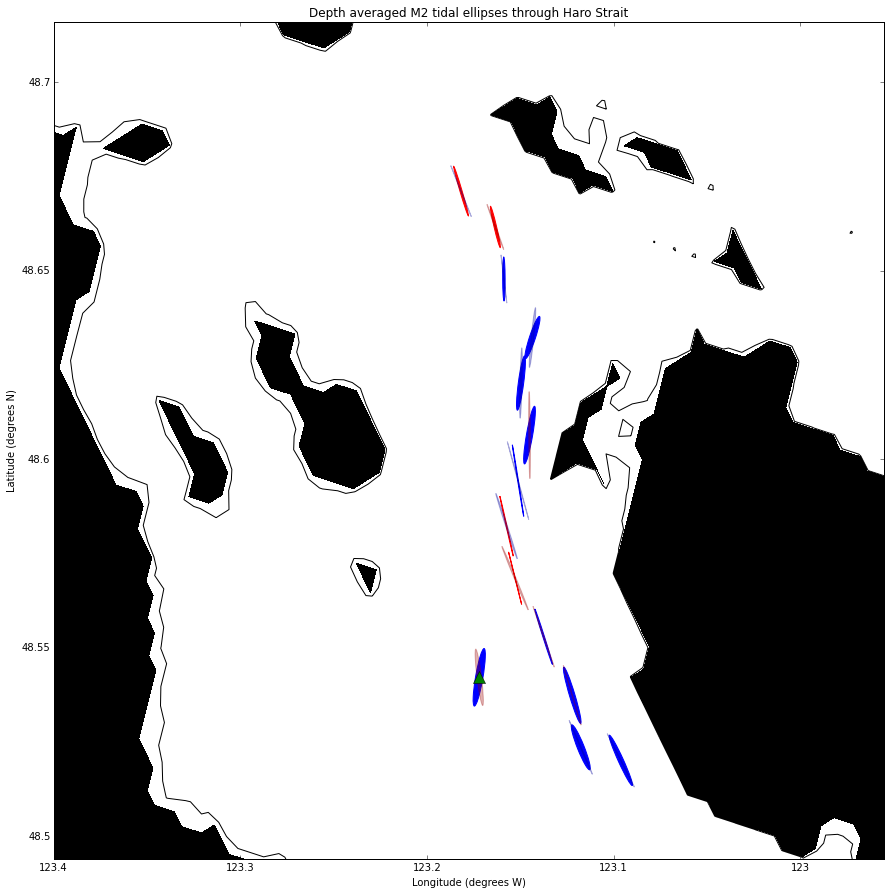

In [15]:
phi=29
fig = plt.figure(figsize=(20,15))
k = np.zeros((898,398)); m = np.zeros((898,398))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 80
scale = 5
imin = min(i)
imax = max(i)

jmin = min(j)
jmax = max(j)

for q in np.arange(jmin-ex,jmax+ex):
    for l in np.arange(imin-ex,imax+ex):
        k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
        m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 

for index, x, y in zip(count, i ,j):
    if parh_av[index,1] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ellsc = Ellipse(xy=(m[y,x],k[y,x]), width=scale*parh_av[index,0], 
                        height=scale*parh_av[index,1], angle=parh_av[index,2],
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)
    
    if parhf[index,1] > 0:
        thec = [0,0,0.6, 0.3]
    else:
        thec = [0.6,0,0, 0.3]
    ellsc = Ellipse(xy=(m[y,x],k[y,x]), width=scale*parhf[index,0],
                        height=scale*parhf[index,1], angle=parhf[index,2],
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)
    
#Plot the Haro Strait current meter location    
ax.plot(m[jH,iH], k[jH,iH],'g^', markersize=12)   

#Values from EllipsesComparisonswithForemanModel notebook
model = [0.70, 0.10, 79, 18.63 , 0.68, -0.06, 98, 301.13]

if model[1] > 0:
    thec = 'b'
else:
    thec = 'r'
ellsc = Ellipse(xy=(m[jH,iH],k[jH,iH]), width=scale*model[0], 
                    height=scale*model[1], angle=model[2],
                    color=thec)
ax.add_artist(ellsc)
ellsc.set_facecolor(thec)

if model[5] > 0:
    thec = [0,0,0.6, 0.3]
else:
    thec = [0.6,0,0, 0.3]
ellsc = Ellipse(xy=(m[jH,iH],k[jH,iH]), width=scale*model[4],
                    height=scale*model[5], angle=model[6],
                    color=thec)
ax.add_artist(ellsc)
ellsc.set_facecolor(thec)

# y-axis in k, but labelled in latitude
ax.set_ylim(375,425)
slope = (lats[jmax,imax]-lats[jmin,imin])/(k[jmax,imax]-k[jmin,imin])
mylist = (k[jmax,imax]+(np.arange(48.335, 48.58, 0.05)-
                           lats[jmin,imin])/slope).tolist()
labels = ['48.5','48.55', '48.6', '48.65', '48.7', '48.75']
ax.set_yticks(mylist)
ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
# x-axis in m, but labelled in longitude
ax.set_xlim(30,80)
slope = (lons[jmax,imax]-lons[jmin,imin])/(m[jmax,imax]-m[jmin,imin])
mylist = (m[jmax,imax]+(np.arange(-123.4,-123,0.1)-
                        lons[jmin,imin])/slope).tolist()
labels = ['123.4','123.3', '123.2', '123.1', '123']
ax.set_xticks(mylist)
ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')

# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
        bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
ax.contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
ax.set_title('Depth averaged M2 tidal ellipses through Haro Strait')

print "red is clockwise"

##Line graph with observations

In [17]:
parameter = ['major-axis', 'minor-axis', 'inclination', 'phase']
unit = ['m/s' ,'m/s','deg', 'deg']
obs = np.ones((13))*0.513
obspha = np.ones((13))*321
Hlat = np.ones((2))*48.537579
y = [0.4,1.2]

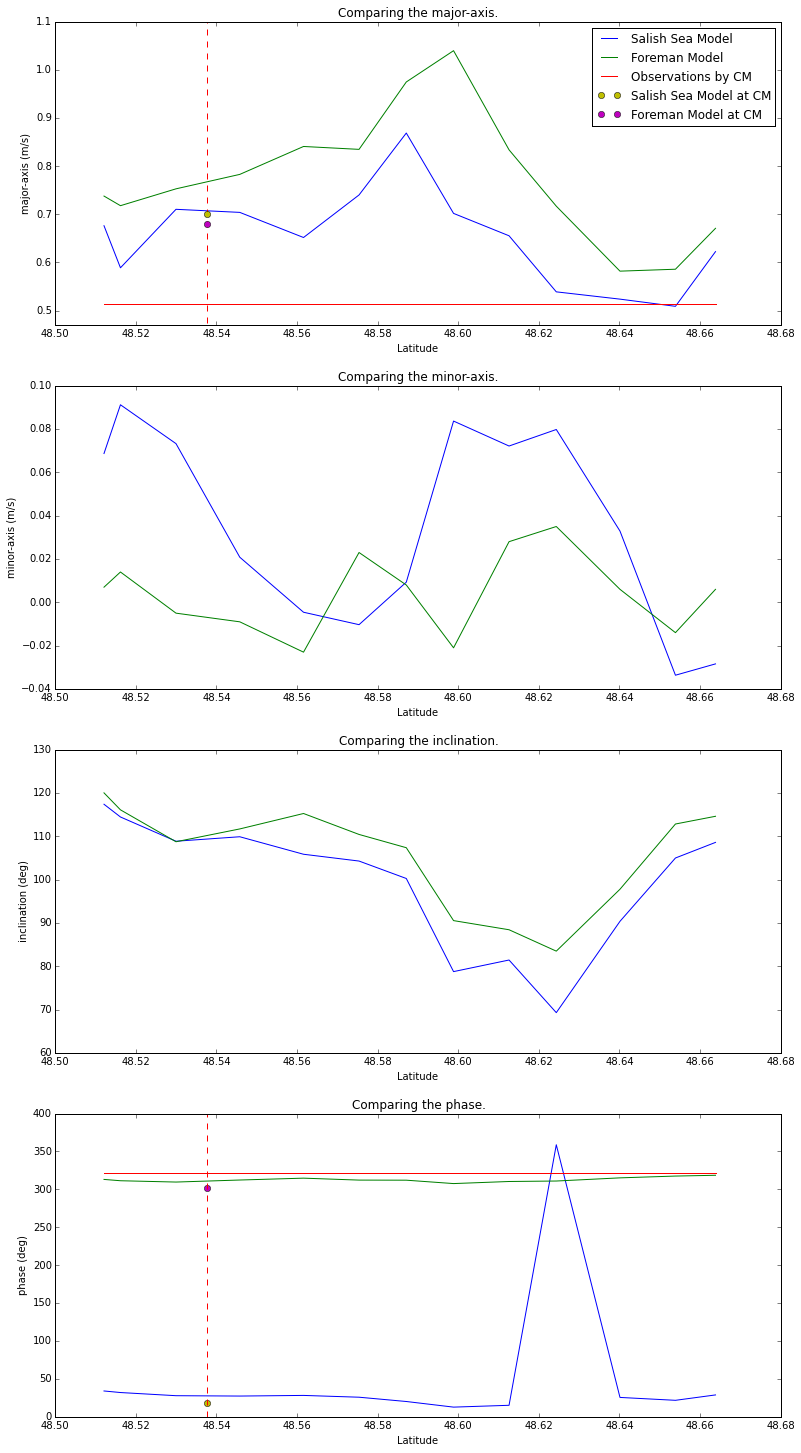

In [23]:
fig, (ax0, ax1, ax2, ax3)= plt.subplots(4,1,figsize=(13,25))

for ax , k, par, u in zip([ax0, ax1, ax2, ax3], [0,1,2,3], parameter, unit):
    ax.plot(lat[:],parh_av[:,k], '-', label='Salish Sea Model')
    ax.plot(lat[:], parhf[:,k], '-', label='Foreman Model')
    ax.set_title('Comparing the {}.'.format(par))
    ax.set_xlabel('Latitude')
    ax.set_ylabel('{} ({})'.format(par,u))
ax0.plot(Hlat, y, 'r--')
ax0.set_ylim([0.47,1.1])
ax0.plot(lat[:], obs, label='Observations by CM')
ax0.plot(48.537579, model[0], 'yo', label = 'Salish Sea Model at CM')
ax0.plot(48.537579, model[4], 'mo', label = 'Foreman Model at CM')
ax3.plot(lat[:], obspha, label='Observations by CM')
ax3.plot(48.537579, model[3], 'yo', label = 'Salish Sea Model at CM')
ax3.plot(48.537579, model[7], 'mo', label = 'Foreman Model at CM')
ax3.plot(Hlat, [0,400], 'r--')
ax0.legend(loc=0)